In [1]:
from EEG2CodeKeras import (basearchi,
                           basearchitest_batchnorm,
                           basearchi_patchembedding,
                           basearchi_patchembeddingdilation,
                           trueVanilliaEEG2Code,
                           vanilliaEEG2Code,
                           vanilliaEEG2Code2,
                           EEGnet_Inception)
from _utils import make_preds_accumul_aggresive, make_preds_pvalue


from sklearn.model_selection import train_test_split
from tensorflow import keras
import mne
import os

import sys
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt



2023-09-08 14:28:57.037759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 14:28:57.165406: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-08 14:28:57.688300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-08 14:28:57.688411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

2023-09-08 14:28:59.799270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 14:28:59.804961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 14:28:59.805421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
fps = 60
sfreq = 500


## Path to the data

In [4]:
sfreq = 500

participant = 'Fred'
# path = '/'.join(['/home/dcas/k.cabrera/Data/DRY', participant])
# path = '/home/dcas/k.cabrera/Data/SETNOP2'
n_class=4
fps = 60
window_size = 0.25

# file_name = '_'.join([participant, 'mseq40.set'])
# file_name = '_'.join([participant, 'mseq100.set'])
# file_name = '_'.join([participant, 'burst40.set'])
# file_name = '_'.join([participant, 'burst100.set'])
# file_name = '/'.join([path,  participant+'_whitemseq.set'])
file_name = '_'.join([participant, 'burst', 'oi_1.set'])


In [5]:
# participant = 'P3'
# path = '/home/dcas/k.cabrera/Data/SET'
# n_class=11


# file_name = '_'.join([participant, 'whitemseq.set'])


#### Load channel positions

## Load the raw data and small pre-process
1. Drop the ACC channels and the shitty channels near ears
2. Average re-referencing
4. Extract 2.2s epochs using events

In [6]:
raw = mne.io.read_raw_eeglab(os.path.join(path, file_name), preload=True, verbose=False)

In [7]:

print(raw.ch_names)
# to_drop = ["P9", "P10", "TP9", "TP10", "10", "21"]
# raw = raw.drop_channels([ch for ch in raw.ch_names if ch in to_drop])
# # raw = raw.drop_channels(["10", "21"])
# keep = ["O1", "O2", "Oz", "P7", "P3", "P4", "P8", "Pz"]
# keep = ["16", "18", "17", "15", "14", "19", "20", "13"] # electrodes to keep
# raw = raw.drop_channels([i for i in raw.ch_names if i not in keep])

raw = raw.filter(l_freq=50.1, h_freq=49.9, method="iir", verbose=True)
# raw.resample(480, npad='auto')
# Average re-referencing
mne.set_eeg_reference(raw, 'average', copy=False, verbose=False)
#raw = raw.filter(l_freq=5, h_freq=45, method="fir", verbose=True)
n_channels = len(raw.ch_names)
print("Channels :", n_channels)

['EEG 000', 'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', 'EEG 020', 'EEG 021', 'EEG 022', 'EEG 023', 'EEG 024', 'EEG 025', 'EEG 026', 'EEG 027', 'EEG 028', 'EEG 029', 'EEG 030', 'EEG 031']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 50 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.90, 50.10 Hz: -6.02, -6.02 dB

Channels : 32


In [8]:
# Strip the annotations that were script to make them easier to process
events, event_id = mne.events_from_annotations(raw, event_id='auto', verbose=False)
to_remove = []
for idx in range(len(raw.annotations.description)):
    if (('collects' in raw.annotations.description[idx]) or
        ('iti' in raw.annotations.description[idx]) or
        (raw.annotations.description[idx] == '[]')):
        to_remove.append(idx)
    else:
        code = raw.annotations.description[idx].split('_')[0]
        lab = raw.annotations.description[idx].split('_')[1]
        code = code.replace('\n', '')
        code = code.replace('[', '')
        code = code.replace(']', '')
        code = code.replace(' ', '')
        raw.annotations.description[idx] = code + '_' + lab

to_remove = np.array(to_remove)
if len(to_remove) > 0:
    raw.annotations.delete(to_remove)
# Get the events
events, event_id = mne.events_from_annotations(raw, event_id='auto', verbose=False)
shift = 0.0
# Epoch the data following event
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=shift, \
            tmax=2.2+shift, baseline=(None, None), preload=False, verbose=False)
labels = epochs.events[..., -1]
labels -= np.min(labels)
data = epochs.get_data()
info_ep = epochs.info

Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped


### Transform a code in `str` to a code in np.array

In [9]:
def code2array(code):
    tmp = []
    for idx, c in enumerate(code[:-2]):
        if c == '5' or c == '.':
            continue
        elif c == '0':
            if code[idx+2] == '5':
                tmp.append(0.5)
            else:
                tmp.append(0)
        else:
            tmp.append(1)
    if code[-1] == '.':
        if code[-2] == '0':
            tmp.append(0)
        else:
            tmp.append(1)
    return np.array(tmp)

### Build a dictionnary that contains all the code in the np.array format

In [10]:
from collections import OrderedDict
codes = OrderedDict()
for k, v in event_id.items():
    code = k.split('_')[0]
    code = code.replace('.','').replace('2','')
    idx = k.split('_')[1]
    if 'randomslowwhite' in file_name:
        codes[v-1] = code2array(code) 
    else:
        codes[v-1] = np.array(list(map(int, code)))

### Define train/test split and windows size
Here we use only the first 7 blocks as calibrition and 8 others would be used as testing

In [11]:
codes[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
sfreq = int(epochs.info['sfreq'])
n_samples_windows = int(window_size*sfreq)
n_trial_per_class = int(len(data)/n_class)

n_cal = 7


data_train = data[:n_class*n_cal]
labels_train = labels[:n_class*n_cal]
data_test = data[n_class*n_cal:]
labels_test = labels[n_class*n_cal:]


### Slice the epoch in windows
The network is not processing full epochs but windows of 250ms. So each epoch is cut into window and the following code (`0` or `1`) is associated as label.

In [13]:
def to_window_old(data, labels):
    length = int((2.2-window_size)*sfreq)
    X = np.empty(shape=((length)*data.shape[0], n_channels, n_samples_windows))
    y = np.empty(shape=((length)*data.shape[0]), dtype=int)
    print(length)
    print(n_samples_windows)
    count = 0
    for trial_nb, trial in enumerate(data):
        lab = labels[trial_nb]
        c = codes[lab]
        code_pos = 0
        for idx in range(length):
            X[count] = trial[:, idx:idx+n_samples_windows]
            if idx/sfreq >= (code_pos+1)/fps:
                code_pos += 1 
            y[count] = int(c[code_pos])
            count += 1

    X = np.expand_dims(X, 1)
    X = X.astype(np.float32)
    y = np.vstack((y,np.abs(1-y))).T
    return X, y

In [14]:
def to_window(data, labels, win_size, data_freq, code_freq, offset=0,
              focus_rising=None, pre_rising=0, post_rising=0,
              focus_falling=None, pre_falling=0, post_falling=0):
    length = int((2.2-win_size)*data_freq)
    X = np.empty(shape=((length)*data.shape[0], n_channels, n_samples_windows))
    Y = np.empty(shape=((length)*data.shape[0]), dtype=int)
    for trial_nb, trial in enumerate(data):
        lab = labels[trial_nb]
        c = codes[lab]
        labels_upsampled = np.repeat(c, sfreq//code_freq)
        labels_upsampled = np.concatenate((np.zeros(int(offset*data_freq), dtype=int), np.array(labels_upsampled)))
        if (focus_rising is not None) or (focus_falling is not None):
            hi_indices = []
            low_indices = []
            for idx in range(1, len(labels_upsampled)):
                if (focus_rising is not None) and (labels_upsampled[idx-1] == 0) and (labels_upsampled[idx] == 1):
                    hi_indices.append(idx)
                elif (focus_falling is not None) and (labels_upsampled[idx-1] == 1) and (labels_upsampled[idx] == 0):
                    low_indices.append(idx)
            focused_labels = np.zeros(length)
            pre_rising_frames = int(sfreq*pre_rising)
            post_rising_frames = int(sfreq*post_rising)
            pre_falling_frames = int(sfreq*pre_falling)
            post_falling_frames = int(sfreq*post_falling)
            for idx in hi_indices:
                focused_labels[idx-pre_rising_frames:idx+post_rising_frames+1] = 1
            for idx in low_indices:
                focused_labels[idx-pre_falling_frames:idx+post_falling_frames+1] = 1
        else:
            focused_labels = labels_upsampled.copy()
            
        for idx in range(length):
            # print('Xidx:', trial_nb*length+idx, "Tidxm:", idx, 'TidxM:', idx +
            #       n_samples_windows, 'Ltrial', trial[:, idx:idx+n_samples_windows].shape)
            X[trial_nb*length+idx] = trial[:, idx:idx+n_samples_windows]
            Y[trial_nb*length+idx] = focused_labels[idx]
    X = np.expand_dims(X, 1)
    X = X.astype(np.float32)
    Y = np.vstack((Y,np.abs(1-Y))).T
    return X, Y

In [15]:
data_train.shape

(28, 32, 1101)

In [16]:
window_size = 0.25
# X, Y = to_window_old(np.array(data_train[:1]), labels_train[:1])
# X_train, Y_train = to_window_old(data_train, labels_train)
# X_test, Y_test = to_window_old(data_test, labels_test)
# print(Y[:,0])
X_train, Y_train = to_window_old(data_train, labels_train)#, 0.25, sfreq, 60)
X_test, Y_test = to_window_old(data_test, labels_test)#, 0.25, sfreq, 60)
# print(codes[labels_train[0]])
# print(np.array(Y_train[:,0]))

975
125
975
125


### Normalization using stats from the train set

In [17]:
X_std = X_train.std(axis=0)
X_train /= X_std + 1e-8
X_std = X_test.std(axis=0)
X_test /= X_std + 1e-8

### Balance classes
Our classes are unbalanced, there are more `1` than `0` in the train set (the stimulation is more often ON than OFF).  
We will use a random under sampler to make it balance.

In [18]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(len(Y_train[Y_train[:, 0] == 1]))
print(Y_test.shape)
print(len(Y_test[Y_test[:, 0] == 1]))


(27300, 1, 32, 125)
(31200, 1, 32, 125)
(27300, 2)
1344
(31200, 2)
1536


In [19]:

rus = RandomUnderSampler()
counter=np.array(range(0,len(Y_train))).reshape(-1,1)
index,_ = rus.fit_resample(counter,Y_train[:,0])
X_train = np.squeeze(X_train[index,:,:,:], axis=1)
Y_train = np.squeeze(Y_train[index])
rus = RandomUnderSampler()
counter=np.array(range(0,len(Y_test))).reshape(-1,1)
index,_ = rus.fit_resample(counter,Y_test[:,0])
X_test = np.squeeze(X_test[index,:,:,:], axis=1)
Y_test = np.squeeze(Y_test[index])

In [20]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(2688, 1, 32, 125)
(2688, 2)
(3072, 1, 32, 125)
(3072, 2)


In [21]:
print(len(Y_train[Y_train[:,0] == 0]))
print(len(Y_train[Y_train[:,0] == 1]))
print(len(Y_test[Y_test[:,0] == 0]))
print(len(Y_test[Y_test[:,0] == 1]))

1344
1344
1536
1536


### Pick an architecture

In [22]:
#  clf = basearchi_patchembedding(windows_size = n_samples_windows, n_channel_input = n_channels) # other stim
# clf = basearchi_patchembeddingdilation(windows_size = n_samples_windows, n_channel_input = n_channels) # burst
# clf = vanilliaEEG2Code(windows_size = n_samples_windows, n_channel_input = n_channels) # burst
# clf = trueVanilliaEEG2Code(windows_size = n_samples_windows, n_channel_input = n_channels) # burst
# clf = basearchitest(windows_size = n_samples_windows, n_channel_input = n_channels)
#c lf = basearchitest_batchnorm(windows_size = n_samples_windows, n_channel_input = n_channels)
# clf = EEGnet_Inception(windows_size = n_samples_windows, n_channel_input = n_channels)
clf = basearchi(windows_size = n_samples_windows, n_channel_input = n_channels)
clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 1, 125)        528       
                                                                 
 batch_normalization (BatchN  (None, 16, 1, 125)       48        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 1, 63)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 1, 63)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 1, 63)          4104      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 1, 63)         2

2023-09-08 14:29:02.022635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 14:29:02.023311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 14:29:02.023943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 14:29:02.024433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [23]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(2688, 1, 32, 125)
(2688, 2)
(3072, 1, 32, 125)
(3072, 2)


### Cut the train in train and valid
Also set some HP of the network

In [24]:
X_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42, shuffle=True)
batchsize = 128 #128 # 64 for burst
epochs = 45 #45 # 20 for burst

### Attach an optimizer and train the network

res_X_train=[]
for i in range(len(X_train)):
    res_X_train.append(np.array(X_train[i:i+1]).reshape(n_samples_windows, n_channels, 1))
res_X_val=[]
for i in range(len(x_val)):
    res_X_val.append(np.array(x_val[i:i+1]).reshape(n_samples_windows, n_channels, 1))

np.array(res_X_val).shape

np.array(res_X_train).shape

In [25]:
lr = 1e-3
weight_decay = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
clf.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
history = clf.fit(np.array(X_train), y_train,
                  batch_size=batchsize, epochs=50,
                  validation_data=(np.array(x_val), y_val), shuffle=True)
keras.backend.clear_session()

Epoch 1/50


2023-09-08 14:29:04.156257: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


19/19 [==============================] - 2s 22ms/step - loss: 0.7325 - accuracy: 0.5502 - val_loss: 0.6905 - val_accuracy: 0.6134
Epoch 2/50
19/19 [==============================] - 0s 5ms/step - loss: 0.6590 - accuracy: 0.6110 - val_loss: 0.5725 - val_accuracy: 0.7286
Epoch 3/50
19/19 [==============================] - 0s 5ms/step - loss: 0.6036 - accuracy: 0.6829 - val_loss: 0.4972 - val_accuracy: 0.7918
Epoch 4/50
19/19 [==============================] - 0s 5ms/step - loss: 0.5470 - accuracy: 0.7325 - val_loss: 0.4809 - val_accuracy: 0.7881
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 0.5209 - accuracy: 0.7499 - val_loss: 0.4575 - val_accuracy: 0.7844
Epoch 6/50
19/19 [==============================] - 0s 5ms/step - loss: 0.5055 - accuracy: 0.7569 - val_loss: 0.4193 - val_accuracy: 0.8104
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.4573 - accuracy: 0.7879 - val_loss: 0.3918 - val_accuracy: 0.8178
Epoch 8/50
19/19 [============

### Model and accuracy and loss
Just check that the model learnt something

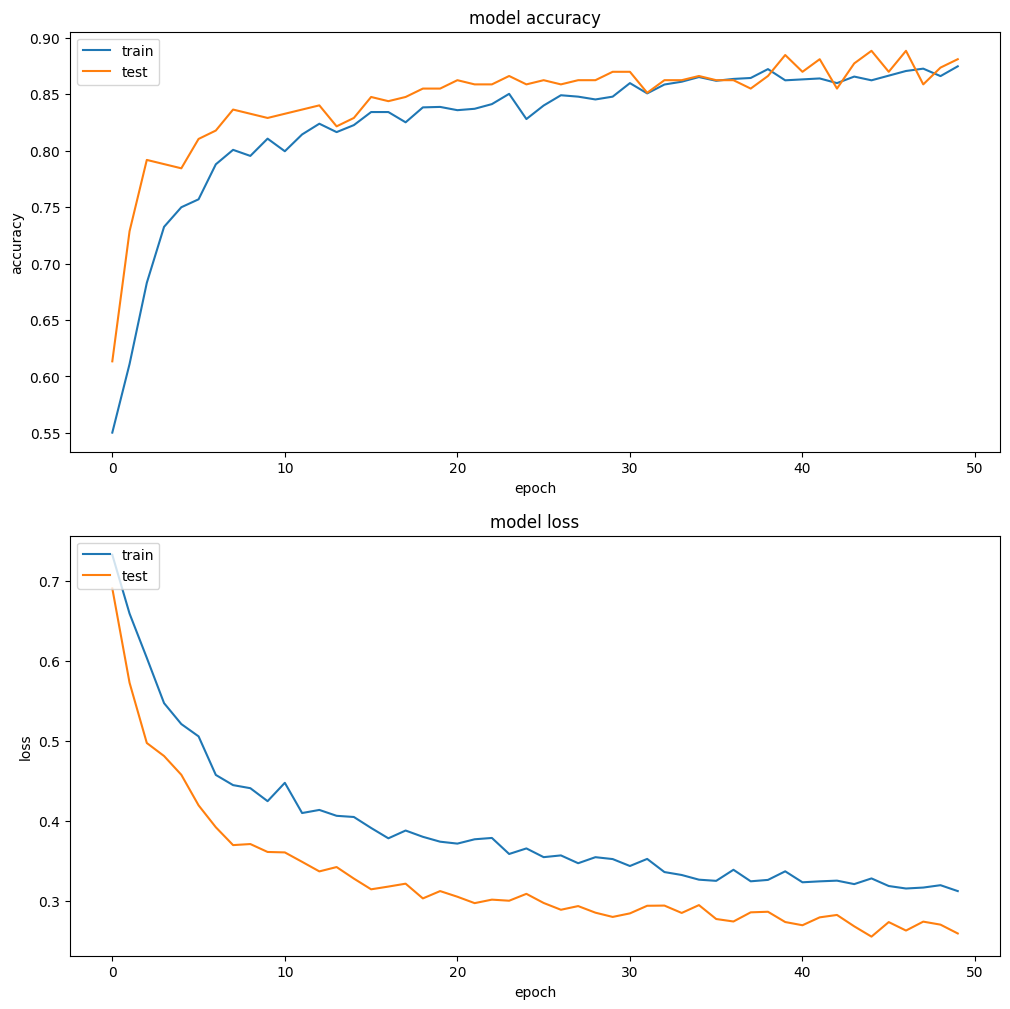

In [26]:
plt.figure(figsize=(12,12))
# summarize history for accuracy
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
print()


filename = ''
np.save(filename + "std_from_calibration", X_std)
model_filename = os.path.join(os.getcwd(), filename + '0.7' + "trainedmodel")
# Save the model if calibration was done
clf.save(model_filename)
keras.backend.clear_session()

## Vizualize learned filters
### Raw vizualiation of 1D convolutinal kernel of the first layer --> spatial filters

In [27]:
# # We first visualize the learned patch embeddings.
# patch_embeddings = clf.layers[0].get_weights()[0]
# weights = patch_embeddings
# # First, apply min-max normalization to the
# # given weights to avoid isotrophic scaling.
# p_min, p_max = weights.min(), weights.max()
# weights = (weights - p_min) / (p_max - p_min)

# # Visualize all the filters.
# num_filters = 10
# plt.figure(figsize=(16, 2))
# idx = 1
# for i in range(num_filters):
#     current_weight = weights[:, :, :, i]
#     if current_weight.shape[-1] == 1:
#         current_weight = current_weight.squeeze()
#     ax = plt.subplot(1, 10, idx)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.plot(current_weight)
#     idx += 1

### Viz of the corresponding topo maps

In [28]:
# spatialfilts = clf.get_layer("conv2d").get_weights()[0]
# spatialfilts = np.squeeze(spatialfilts)
# spatialfilts = np.swapaxes(spatialfilts, 1, 0)

### Predict on the test set
The predictions are made on windows to regress the code.  
Here we divide the prediction in 10 fold to avoid OOM from the GPU.

In [29]:
keras.backend.clear_session()

In [30]:
keras.backend.clear_session()
y_pred = clf.predict(X_test)[:,0]
y_pred = np.array(y_pred)

96/96 [==============================] - 0s 1ms/step


In [31]:
y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in y_pred])
y_test_norm = np.array([0 if y[0] == 0 else 1 for y in Y_test])

In [58]:
import sklearn.metrics
import math
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test_norm, y_pred_norm).ravel()
print("True positives:", tp)
print("True negatives:", tn)
print("False positives:", fp)
print("False negatives:", fn)
print("Accuracy:", (tp+tn)/len(y_test_norm))
print("Sensitivity:", sen:=tp/(tp+fn))
print("Precision:", pre:=tp/(tp+fp))
print("Fowlkes-Mallows:", math.sqrt(sen*pre))


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous targets

### Convert prediction on windows (regressed code) to label prediction

It is offline and synchronous, so we will:
1. First create a `code_buffer` that contains the regressed code on the full epoch (2.2s - the last window)
    - The refresh rate of the EEG device (500 Hz) is faster than the refress rate of the screen (60Hz), so we average predictions (500/60~8 samples) so they correspond to each flip of the screen.
2. Starting from `min_len` (in number of samples), we compute Pearson correalation with the bank of templates code to find the closest one
    - If the most correlated code has a significantely bigger correlation compared to the second one (50% bigger) and the p_value is significative then the trial is classified and we move to the next one
    - If the thresholds are not reached, then we add samples (with a step of 3) to have a longer trial and re-do the computation
    - The thresholds can never been reached in 2.2s, then the trial is not classified.

In [33]:
# p_best_score = 0
# p_best_ratio = 0
# p_best_acc = 0
# p_best_values = ()

# for p in np.logspace(0,-5, 6):
#     for dr in np.linspace(0.2, 0.8, 7):
#         labels_pred, _, mean_long = make_preds_pvalue(y_pred, codes, min_len=70, sfreq=sfreq, obj_p=p)
#         ratio = len(labels_pred[labels_pred != -1])/len(labels_pred)
#         accuracy = accuracy_score(labels_test[labels_pred != -1], labels_pred[labels_pred != -1])
#         score = ratio*accuracy
#         if ratio >= p_best_ratio:
#             p_best_score = score
#             p_best_acc = accuracy
#             p_best_ratio = ratio
#             p_best_values = (p, dr)
#         print("==========", p, "+", dr,':',ratio,'--',accuracy,'--',score, '--', np.mean(mean_long))
# print("Best score", p_best_score)
# print("Best values", p_best_values)            
        

### Compute accuracy score and accuracy score when a prediction is made (discard not classified trials)

### Other classification method
Same as before but the classification method is different. Instead of thresholds to reach, if when increasing trial lengt a code correllated the most 40 times in a row then the trial is labeled.

In [34]:
# import importlib
# importlib.reload(_utils)
# from _utils import make_preds_accumul_aggresive, make_preds_pvalue



In [59]:
acc_best_score=0
acc_best_ratio=0
acc_best_acc=0
acc_best_value = 0
# for minlen in np.linspace(10, 60, 10):
for cons in [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    
    labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
        y_pred_norm, codes, min_len=30, sfreq=sfreq, consecutive=cons, window_size=window_size
    )
    ratio = np.round(len(labels_pred_accumul[labels_pred_accumul != -1])/len(labels_pred_accumul), 2)
    accuracy = np.round(accuracy_score(labels_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
    score = np.round(ratio*accuracy,2)
    print("==========", cons, ':', ratio, '--', accuracy,
        '--', score, '--', np.mean(mean_long_accumul))
    if accuracy > acc_best_acc:
        acc_best_score = score
        acc_best_value = cons
        acc_best_acc = accuracy
        acc_best_ratio = ratio

print("Best accuracy", acc_best_acc)
print("Best ratio", acc_best_ratio)
print("Best score", acc_best_score)
print("Best values", acc_best_value)


/home/dcas/k.cabrera/miniconda3/envs/ISAE/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/dcas/k.cabrera/miniconda3/envs/ISAE/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 32 but corresponding boolean dimension is 3

In [37]:
accuracy_score(labels_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 32 but corresponding boolean dimension is 3

In [60]:
labels_pred_accumul, aaaaa, mean_long_accumul = make_preds_accumul_aggresive(
        y_pred_norm, codes, min_len=30, sfreq=sfreq, consecutive=15, window_size=window_size
    )

/home/dcas/k.cabrera/miniconda3/envs/ISAE/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/dcas/k.cabrera/miniconda3/envs/ISAE/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [61]:
len(labels_pred_accumul)


3

In [62]:
codes

OrderedDict([(0,
              array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
             (1,
              array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      